<h1>Data Analyst @ OneSoil - Test Case</h1>

Представьте, что вы начали работать аналитиком в маркетплейс. Вас просят проанализировать отзывы и оценки покупателей.

<b>Подключитесь к базе данных и постарайтесь ответить на следующие вопросы:</b>

1. Можно ли при анализе оценок и отзывов полагаться только на данные *as is*? Есть ли какие-то особенности в том как клиенты дают обратную связь, которые надо принять во внимание? Если да, какие есть способы, чтобы их учесть?
2. Каково распределение отзывов? По пользователям, по регионам, по товарам, продавцам? Какой пользователь оставил больше всего оценок, отзывов? Какие товары получают больше всего высоких оценок, а какие - больше всего низких? Можно ли с помощью имеющихся данных понять почему? Если нет, какие данные, вы бы запросили еще?
3. Есть ли связь между оценками и продажами? Например, оцените вероятность возвращения клиента после высокой оценки и после низкой. Что будет со средним чеком?
4. Есть ли связь оценок и сроков доставки заказов?
5. О чем пишут в отзывах? Какие характеристики товаров волнуют пользователей в первую очередь? Какая тональность преобладает? Можно ли по отзыву предсказать оценку? 
6. Может быть вы хотите обратить внимание на что-нибудь еще? 😉

In [1]:
import psycopg2
import seaborn as sns
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import re
import nltk
import matplotlib.pyplot as plt

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
pd.options.display.max_columns = 50

In [3]:
# connection
conn = psycopg2.connect("""
    host=rc1c-5lsfxv5qer0uol30.mdb.yandexcloud.net
    port=6432
    dbname=olist
    user=user1
    password=olistolist
    target_session_attrs=read-write
    sslmode=verify-full
""") 

# postgresql version
q = conn.cursor()
q.execute('SELECT version()')
print(q.fetchone())

# list of tables
q.execute("""SELECT table_name FROM information_schema.tables
        WHERE table_schema = 'public'""")

rows = q.fetchall()

tables = []
for row in rows:
    tables.append(row[0])

('PostgreSQL 13.4 (Ubuntu 13.4-201-yandex.50204.1072273362) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0, 64-bit',)


In [4]:
tables

['closed_deals',
 'customers',
 'geolocation',
 'marketing_qualified_leads',
 'order_items',
 'order_payments',
 'order_reviews',
 'orders',
 'products',
 'sellers']

In [5]:
# загрузим необходмые таблицы
cur_tables = [
#     'closed_deals',
    'customers',
    'geolocation',
#     'marketing_qualified_leads',
    'order_items',
    'order_payments',
    'order_reviews',
    'orders',
    'products',
    'sellers'
]

for t in tables:
    if t in cur_tables:
        sql = "select * from "+t+";"
        tmp = sqlio.read_sql_query(sql, conn)
        exec('{} = tmp.copy()'.format(t))
        print('-----',t)
        exec('{}.name = "{}"'.format(t,t))
        exec('print({}.columns)'.format(t))
        print()

----- customers
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

----- geolocation
Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')

----- order_items
Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

----- order_payments
Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

----- order_reviews
Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

----- orders
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'ord

In [6]:
conn.close()

# DATA

https://www.kaggle.com/olistbr/brazilian-ecommerce

### Data Schema

<img src=https://i.imgur.com/HRhd2Y0.png>

Каково распределение отзывов? По пользователям, по регионам, по товарам, продавцам? Какой пользователь оставил больше всего оценок, отзывов? Какие товары получают больше всего высоких оценок, а какие - больше всего низких? Можно ли с помощью имеющихся данных понять почему? Если нет, какие данные, вы бы запросили еще?

In [7]:
def get_relation(df, col1, col2):
    """Выводит отношение между двумя столбцами в массиве.
    
    Keywords arguments:
    df - исходный датафрейм
    col1 - стобец 1
    col2 - столбец 2
   
    """
    
    first_df = df[[col1, col2]].drop_duplicates().groupby(col1, as_index=False).agg({col2:'count'})
    second_df = df[[col1, col2]].drop_duplicates().groupby(col2, as_index=False).agg({col1:'count'})
    
    first_max = first_df[col2].max()
    second_max = second_df[col1].max()

    if (first_max==1) & (second_max==1):
        return 'one-to-one'
    elif (first_max==1) & (second_max!=1):
        return 'many-to-one'
    elif (first_max!=1) & (second_max==1):
        return 'one-to-many'
    elif (first_max!=1) & (second_max!=1):
        return 'many-to-many'
    else:
        return 'indefinite'

    
def print_relations(df, fields):
    """Выводит отношения между столбцами в fields.
    
    Keywords arguments:
    df - исходный датафрейм
    fields - список столбцов
   
    """
    for i in range(len(fields)-1):
        for j in range(i+1,len(fields)):
            col1 = fields[i]
            col2 = fields[j]
            print(df.name.upper(),':',col1, '-', col2, ':', get_relation(df[[col1, col2]], col1, col2))

In [8]:
order_reviews[['order_id','review_id','review_score']].head()

,order_id,review_id,review_score
0,73fc7af87114b39712e6da79b0a377eb,7bc2406110b926393aa56f80a40eba40,4
1,a548910a1c6147796b98fdf73dbeba33,80e641a11e56f04c1ad469d5645fdfde,5
2,f9e4b658b201a9f2ecdecbb34bed034b,228ce5500dc1d8e020d8d1322874b6f0,5
3,658677c97b385a9be170737859d3511b,e64fb393e7b32834bb789ff8bb30750e,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,f7c4243c7fe1938f181bec41a392bdeb,5


In [9]:
# отношение столбцов
print_relations(order_reviews, ['order_id','review_id'])

ORDER_REVIEWS : order_id - review_id : many-to-many


In [10]:
orders.groupby(['order_status']).size().sort_values(ascending=False)

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
dtype: int64

In [11]:
# рассмотрим только delivered orders
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [12]:
# отношение столбцов
print_relations(orders, ['order_id','customer_id'])

ORDERS : order_id - customer_id : one-to-one


In [13]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [14]:
# отношение столбцов
print_relations(order_items, ['order_id','product_id','seller_id'])

ORDER_ITEMS : order_id - product_id : many-to-many
ORDER_ITEMS : order_id - seller_id : many-to-many
ORDER_ITEMS : product_id - seller_id : many-to-many


In [15]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [16]:
# отношение столбцов
print_relations(customers, ['customer_id', 'customer_unique_id','customer_zip_code_prefix','customer_city','customer_state'])

CUSTOMERS : customer_id - customer_unique_id : many-to-one
CUSTOMERS : customer_id - customer_zip_code_prefix : many-to-one
CUSTOMERS : customer_id - customer_city : many-to-one
CUSTOMERS : customer_id - customer_state : many-to-one
CUSTOMERS : customer_unique_id - customer_zip_code_prefix : many-to-many
CUSTOMERS : customer_unique_id - customer_city : many-to-many
CUSTOMERS : customer_unique_id - customer_state : many-to-many
CUSTOMERS : customer_zip_code_prefix - customer_city : many-to-many
CUSTOMERS : customer_zip_code_prefix - customer_state : many-to-one
CUSTOMERS : customer_city - customer_state : many-to-many


In [17]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [18]:
# отношение столбцов
print_relations(products, ['product_id', 'product_category_name'])

PRODUCTS : product_id - product_category_name : many-to-one


In [19]:
products.product_id.count()==products.product_id.nunique()

True

In [20]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [21]:
order_payments.dtypes

order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object

In [22]:
order_payments[order_payments.payment_value.isna()].count()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [23]:
total_order_payments = order_payments[['order_id', 'payment_value']] \
                        .groupby('order_id', as_index=False) \
                        .agg({'payment_value':'sum'})

In [24]:
print('sum_payment_value:',round(total_order_payments.payment_value.sum()))

sum_payment_value: 16008872


In [25]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [26]:
# отношение столбцов
print_relations(sellers, ['seller_id', 'seller_zip_code_prefix','seller_city','seller_state'])

SELLERS : seller_id - seller_zip_code_prefix : many-to-one
SELLERS : seller_id - seller_city : many-to-one
SELLERS : seller_id - seller_state : many-to-one
SELLERS : seller_zip_code_prefix - seller_city : many-to-many
SELLERS : seller_zip_code_prefix - seller_state : many-to-many
SELLERS : seller_city - seller_state : many-to-many


<img src=dataschema.png>

In [27]:
print(order_items.name.upper(),':',order_items.shape)
df = pd.merge(order_items, products, on='product_id', how='outer')
print('+',products.name.upper(),':',df.shape)
df = pd.merge(df, sellers, on='seller_id', how='outer')
print('+',sellers.name.upper(),':',df.shape)
df = pd.merge(df, orders, on='order_id', how='outer')
print('+',orders.name.upper(),':',df.shape)
df = pd.merge(df, customers, on='customer_id', how='outer')
print('+',customers.name.upper(),':',df.shape)
df = pd.merge(df, order_reviews, on='order_id', how='outer')
print('+',order_reviews.name.upper(),':',df.shape)
df.head()

ORDER_ITEMS : (112650, 7)
+ PRODUCTS : (112650, 15)
+ SELLERS : (112650, 18)
+ ORDERS : (113425, 25)
+ CUSTOMERS : (113425, 29)
+ ORDER_REVIEWS : (114092, 35)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277.0,volta redonda,SP,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,97ca439bc427b48bc1cd7177abe71365,5.0,None,"Perfeito, produto entregue antes do combinado.",2017-09-21,2017-09-22 10:57:03
1,130898c0987d1801452a8ed92a670612,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277.0,volta redonda,SP,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,b11cba360bbe71410c291b764753d37f,5.0,None,"lannister como sempre, entregou certinho e den...",2017-07-14,2017-07-17 12:50:07
2,532ed5e14e24ae1f0d735b91524b98b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277.0,volta redonda,SP,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,af01c4017c5ab46df6cc810e069e654a,4.0,super recomendo,carrinho muito bonito,2018-06-05,2018-06-06 21:41:12
3,6f8c31653edb8c83e1a739408b5ff750,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277.0,volta redonda,SP,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,2017-08-01 18:55:08,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR,8304ff37d8b16b57086fa283fe0c44f8,5.0,None,None,2017-08-10,2017-08-13 03:35:17
4,7d19f4ef4d04461989632411b7e588b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277.0,volta redonda,SP,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,2017-08-10 22:05:11,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG,426f43a82185969503fb3c86241a9535,5.0,None,None,2017-08-25,2017-08-28 00:51:18


In [28]:
# отношение столбцов
df.name = 'total_df'
print_relations(df, ['review_id', 'customer_unique_id'])

TOTAL_DF : review_id - customer_unique_id : many-to-one


Распределение отзывов по пользователям, по регионам, по товарам, продавцам

In [29]:
fields = [
     'customer_unique_id'
    ,'customer_city'
    ,'product_id'
    ,'product_category_name'
    ,'seller_id'
]

for field in fields:
    display(
        df[[field, 'review_id']] \
            .drop_duplicates() \
            .groupby(field) \
            .size() \
            .sort_values(ascending=False) \
            .to_frame() \
            .reset_index() \
            .rename(columns={field:field,0:'count'}) \
            .head(10)
    )

,customer_unique_id,count
0,8d50f5eadf50201ccdcedfb9e2ac8455,17
1,3e43e6105506432c953e165fb2acf44c,8
2,1b6c7548a2a1f9037c1fd3ddfed95f33,7
3,ca77025e7201e3b30c44b472ff346268,7
4,6469f99c1f9dfae7733b25662e7f1782,7
5,de34b16117594161a6a89c50b289d35a,6
6,47c1a3033b8b77b3ab6e109eb4d5fdf3,6
7,dc813062e0fc23409cd255f7f53c7074,6
8,f0e310a6839dce9de1638e0fe5ab282a,6
9,12f5d6e1cbf93dafd9dcc19095df0b3d,6


,customer_city,count
0,sao paulo,15394
1,rio de janeiro,6775
2,belo horizonte,2747
3,brasilia,2112
4,curitiba,1507
5,campinas,1422
6,porto alegre,1370
7,salvador,1217
8,guarulhos,1176
9,sao bernardo do campo,937


,product_id,count
0,99a4788cb24856965c36a24e339b6058,462
1,aca2eb7d00ea1a7b8ebd4e68314663af,430
2,422879e10f46682990de24d770e7f83d,354
3,d1c427060a0f73f6b889a5c7c61f2ac4,321
4,389d119b48cf3043d311335e499d9c6b,311
5,53b36df67ebb7c41585e8d54d6772e08,304
6,368c6c730842d78016ad823897a372db,292
7,53759a2ecddad2bb87a079a1f1519f73,288
8,154e7e31ebfa092203795c972e5804a6,281
9,2b4609f8948be18874494203496bc318,268


,product_category_name,count
0,cama_mesa_banho,9325
1,beleza_saude,8768
2,esporte_lazer,7657
3,informatica_acessorios,6642
4,moveis_decoracao,6405
5,utilidades_domesticas,5855
6,relogios_presentes,5583
7,telefonia,4171
8,automotivo,3880
9,brinquedos,3857


,seller_id,count
0,6560211a19b47992c3666cc44a7e94c0,1842
1,4a3ca9315b744ce9f8e9374361493884,1801
2,cc419e0650a3c5ba77189a1882b7556a,1708
3,1f50f920176fa81dab994f9023523100,1405
4,da8622b14eb17ae2831f4ac5b9dab84a,1310
5,955fee9216a65b617aa5c0531780ce60,1280
6,7a67c85e85bb2ce8582c35f2203ad736,1156
7,ea8482cd71df3c1969d7b9473ff13abc,1142
8,4869f7a5dfa277a7dca6462dcf3b52b2,1125
9,3d871de0142ce09b7081e2b9d1733cb1,1069


Какой пользователь оставил больше всего оценок, отзывов?

In [30]:
df_customers = df[['customer_unique_id','review_id','review_score','review_comment_message']]

fields = [
     'review_score'
    ,'review_comment_message'
]

for field in fields:
    tmp = df_customers.loc[df_customers[field].isna()==False,['customer_unique_id',field]] \
    .groupby('customer_unique_id',as_index=False) \
    .agg({field:'count'})
    
    tmp_max = tmp[field].max()
    
    tmp_group = tmp.groupby(field,as_index=False).agg({'customer_unique_id':list})
    
    list_max = tmp_group.loc[tmp_group[field]==tmp_max,'customer_unique_id'].tolist()[0]
    print('Максимальное количество '+field+' ('+str(tmp_max)+') у пользователей:')
    for i in range(len(list_max)):
        print(list_max[i])
    print()
    print('=============================================================================')
    print()

Максимальное количество review_score (24) у пользователей:
c8460e4251689ba205045f3ea17884a1
d97b3cfb22b0d6b25ac9ed4e9c2d481b


Максимальное количество review_comment_message (21) у пользователей:
4546caea018ad8c692964e3382debd19




In [31]:
# SQL

# connection
conn = psycopg2.connect("""
    host=rc1c-5lsfxv5qer0uol30.mdb.yandexcloud.net
    port=6432
    dbname=olist
    user=user1
    password=olistolist
    target_session_attrs=read-write
    sslmode=verify-full
""") 

# postgresql version
q = conn.cursor()

sql = """
with df as (
    select 
          oi.order_id
        , oi.product_id
        , oi.seller_id
        , p.product_category_name
        , s.seller_zip_code_prefix
        , s.seller_city
        , s.seller_state
        , o.customer_id
        , c.customer_unique_id
        , c.customer_zip_code_prefix
        , c.customer_city
        , c.customer_state
        , r.review_id
        , r.review_score
        , r.review_comment_message
    from order_items oi
    full join 
    (select 
          product_id
        , product_category_name 
    from products) p
    on oi.product_id=p.product_id
    full join
    (select
          seller_id
        , seller_zip_code_prefix
        , seller_city
        , seller_state
    from sellers) s
    on s.seller_id=oi.seller_id
    full join
    (select
          order_id
        , customer_id
    from orders) o
    on o.order_id=oi.order_id
    full join
    (select
          customer_id
        , customer_unique_id
        , customer_zip_code_prefix
        , customer_city
        , customer_state
    from customers) c
    on c.customer_id=o.customer_id
    full join
    (select
          order_id
        , review_id
        , review_score
        , review_comment_message
    from order_reviews) r
    on r.order_id=oi.order_id
),
gc as (
select
      customer_unique_id
    , count(review_score) count_review_score
    , count(review_comment_message) count_review_comment_message 
from df
where customer_unique_id is not null
group by customer_unique_id
)

select customer_unique_id, 'count_review_score' max_count
from gc
where 
    count_review_score in (select max(count_review_score) from gc)
union all
select customer_unique_id, 'count_review_comment_message' max_count
from gc
where 
    count_review_comment_message in (select max(count_review_comment_message) from gc)
;
"""

In [32]:
q.execute(sql)
q.fetchall()

[('c8460e4251689ba205045f3ea17884a1', 'count_review_score'),
 ('d97b3cfb22b0d6b25ac9ed4e9c2d481b', 'count_review_score'),
 ('4546caea018ad8c692964e3382debd19', 'count_review_comment_message')]

In [33]:
conn.close()

Какие товары получают больше всего высоких оценок, а какие - больше всего низких?

будем считать, что все товары в заказе получили одинаковую оценку заказа

In [34]:
df_product = df[['product_category_name','product_id','review_score','review_id']].drop_duplicates()

In [35]:
def score(x):
    if x<3:
        return -1
    elif x>3:
        return 1
    else:
        return 0

In [36]:
df_product['score'] = df_product.review_score.apply(lambda x: score(x))

In [38]:
tmp_product = df_product[['product_id','score','review_id']] \
    .groupby(['product_id','score'], as_index=False) \
    .agg('count') \
    .dropna()

tmp_product['review_sum'] = tmp_product[['product_id','review_id']].groupby('product_id').transform('sum')
tmp_product['review_%'] = tmp_product['review_id']/tmp_product['review_sum']

tmp_product_max = tmp_product.loc[tmp_product['score']==1,'review_id'].max()

tmp_product_group_pos = tmp_product[tmp_product['score']==1] \
    .groupby('review_id',as_index=False) \
    .agg({'product_id':list})

list_0 = tmp_product_group_pos.loc[tmp_product_group_pos['review_id']==tmp_product_max,'product_id'].tolist()[0]
print('Максимальное количество высоких ('+str(tmp_product_max)+') у товаров:')
for i in range(len(list_0)):
    print(list_0[i])

print('======================================================')
tmp_product_max = tmp_product.loc[tmp_product['score']==-1,'review_id'].max()

tmp_product_group_neg = tmp_product[tmp_product['score']==-1] \
    .groupby('review_id',as_index=False) \
    .agg({'product_id':list})

list_1 = tmp_product_group_pos.loc[tmp_product_group_pos['review_id']==tmp_product_max,'product_id'].tolist()[0]
print('Максимальное количество низких ('+str(tmp_product_max)+') у товаров:')
for i in range(len(list_1)):
    print(list_1[i])

Максимальное количество высоких (330) у товаров:
aca2eb7d00ea1a7b8ebd4e68314663af
Максимальное количество низких (75) у товаров:
165f86fe8b799a708a20ee4ba125c289
d285360f29ac7fd97640bf0baef03de0


<AxesSubplot:>

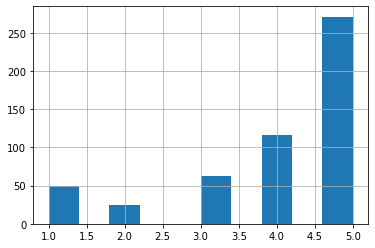

In [39]:
df.loc[df['product_id'].isin(list_0),'review_score'].hist()

<AxesSubplot:>

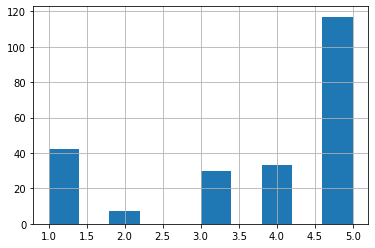

In [40]:
df.loc[df['product_id'].isin(list_1),'review_score'].hist()

______
## Reviews Classification

О чем пишут в отзывах? Какие характеристики товаров волнуют пользователей в первую очередь? Какая тональность преобладает? Можно ли по отзыву предсказать оценку?

In [41]:
order_reviews.dtypes

review_id                          object
order_id                           object
review_score                        int64
review_comment_title               object
review_comment_message             object
review_creation_date       datetime64[ns]
review_answer_timestamp    datetime64[ns]
dtype: object

In [42]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


In [43]:
# проверим количество ревью на одном заказе
# если оценка менялась, то стандартное отклонение будет отлично от нуля
sample_order_reviews = \
    order_reviews[['order_id','review_score','review_comment_message']] \
    .groupby(['order_id'],as_index=False) \
    .agg({'review_score':np.std,'review_comment_message':list}) \
    .sort_values(by='review_score', ascending=False)

# комментарии слепим в список и посчитаем длину списка
sample_order_reviews['review_comment_message'] = \
    sample_order_reviews['review_comment_message'] \
    .apply(lambda x: list(set(x)))

sample_order_reviews['len_review_comment_message'] = \
    sample_order_reviews['review_comment_message'] \
    .apply(lambda x: len(x))

# выведем все заказы с более одним ревью, 
# с условием, что оценка менялась или был изменен комментарий
orders_list = list(
    sample_order_reviews.loc[
        (sample_order_reviews['review_score']>0)|
        (sample_order_reviews['len_review_comment_message']>1),
        'order_id']
)

tmp = order_reviews[order_reviews['order_id'].isin(orders_list)] \
        .sort_values(by=['order_id','review_answer_timestamp'], ascending=False)

print(tmp.shape)
display(tmp)

(639, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
18783,80f25f32c00540d49d57796fb6658535,ff850ba359507b996e8b2fbb26df8d03,5,None,"Envio rapido, produto conforme descrito no anu...",2017-08-22,2017-08-25 11:40:22
41355,39de8ad3a1a494fc68cc2d5382f052f4,ff850ba359507b996e8b2fbb26df8d03,5,None,Envio rapido... Produto 100%,2017-08-16,2017-08-17 11:56:55
27466,5e78482ee783451be6026e5cf0c72de1,ff763b73e473d03c321bcd5a053316e8,3,None,Não sei que haverá acontecido os demais chegaram,2017-11-18,2017-11-18 09:02:48
94505,c56a88a404315a0d9e412c1472dda2c4,ff763b73e473d03c321bcd5a053316e8,5,None,None,2017-11-01,2017-11-01 19:55:52
9898,117b4a19af2b247561f0075f73d6eea1,fe041ba1c9f54016432fa6ee91709dbc,5,None,None,2017-12-20,2017-12-20 22:04:37
42177,9da0796858da97acd8b67578388a3241,fe041ba1c9f54016432fa6ee91709dbc,5,None,"O cartucho está estourado (vazando), já contat...",2017-12-20,2017-12-20 22:03:18
80631,c509f8b367ee5227700c29fcc76a097a,fd95ae805c63c534f1a64589e102225e,5,None,"Recebi dentro do prazo estabelecido, produtos ...",2018-03-04,2018-03-06 10:10:08
51460,eba9ae334beb044f1045c073555df70e,fd95ae805c63c534f1a64589e102225e,5,None,"Produtos entregues no prazo, excelente qualidade",2018-03-01,2018-03-04 01:58:13
86641,24ad2fc85ec000ba4fbfd9841d9a1972,fd61441ba2a7b57e6342862e779b10b0,4,None,"Tem que retirar nos correios, muito incômodo",2017-10-14,2017-10-16 21:23:28
1157,3c625d52413314975e47e144fbc3cb8e,fd61441ba2a7b57e6342862e779b10b0,5,None,None,2017-10-04,2017-10-05 18:02:50


In [44]:
# review_id объеденим в список
# order_id - уникальное значение
# review_score - возьмем последнюю оценку по времени
# review_comment_title - объеденим в список, уберем пропуски, соеденим в одну строку
# review_comment_message - объеденим в список, уберем пропуски, соеденим в одну строку
# review_creation_date - возьмем последюю дату публикации
# review_answer_timestamp - возьмем последюю дату публикации

df_order_reviews = \
    order_reviews[[
         'review_id'
        ,'order_id'
        ,'review_score'
        ,'review_comment_title'
        ,'review_comment_message'
        ,'review_creation_date'
        ,'review_answer_timestamp'
    ]] \
    .sort_values(by=['order_id','review_answer_timestamp'], ascending=False) \
    .groupby(['order_id'],as_index=False) \
    .agg({
         'review_id':list
        ,'review_score':'first'
        ,'review_comment_title':list
        ,'review_comment_message':list
        ,'review_creation_date':'max'
        ,'review_answer_timestamp':'max'
    })

df_order_reviews['review_comment_title'] = df_order_reviews['review_comment_title'].apply(lambda x: '. '.join(map(str, x))).str.replace(r'None.*','')
df_order_reviews['review_comment_message'] = df_order_reviews['review_comment_message'].apply(lambda x: '. '.join(map(str, x))).str.replace(r'None.*','')

In [45]:
print(df_order_reviews.order_id.count())
print(df_order_reviews.order_id.nunique())

98673
98673


#### TF IDF for "review_comment_message"

In [46]:
# nltk.download('stopwords')
# nltk.download('rslp')

stopwords = nltk.corpus.stopwords.words('portuguese')
stemmer = RSLPStemmer()

def words_transform(text, st=True):
    patterns = [
         ['([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}', ' data '] # dates
        ,['[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+', ' dinheiro '] # money
        ,['[\n\r\W]',' '] # breakline and special chars
        ,['http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' link '] # links
        ,['[0-9]+',' numero '] # numero
        ,['([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação '] # negation
        ,['\s+', ' '] # white spaces begin
        ,['^\s', ''] # white spaces end
        ,['[ \t]+$', ''] # white spaces end
    ]

    for pattern in patterns:
        text = re.sub(pattern[0], pattern[1], text)
    
    # stopwords
    text = [word for word in text.lower().split() if word not in stopwords]
    
    # stemmer
    if st==True:
        text = [stemmer.stem(word) for word in text]
    
    return ' '.join(text)

In [47]:
df_order_reviews.loc[df_order_reviews['review_comment_title']!='','review_comment_title'] = df_order_reviews.loc[df_order_reviews['review_comment_title']!='','review_comment_title'] + '. '
df_order_reviews['review_text'] = df_order_reviews[['review_comment_title','review_comment_message']].sum(1)

In [48]:
df_order_reviews['review_text_transform'] = df_order_reviews['review_text'].apply(lambda x: words_transform(x))

In [49]:
df_reviews = df_order_reviews.loc[
    df_order_reviews['review_text_transform']!=''
    ,['review_score','review_text_transform']] \
    .reset_index(drop=True) \
    .rename(columns={'review_score':'score','review_text_transform':'review'})

In [50]:
df_reviews.head()

,score,review
0,5,perfeit produt entreg ant combin
1,5,cheg ant praz previst produt surpreend qual sa...
2,5,gost poi vei praz determin
3,1,descr produt efetu compr detalh pent disfarc r...
4,5,caix produt vei pequen avari rest vei perfeit


In [51]:
# TF-IDF vectors
vec = TfidfVectorizer(max_features=500)
tfidf = vec.fit_transform(df_reviews['review'])

df_reviews['vec'] = tfidf.toarray().tolist()

In [52]:
df_reviews.head()

,score,review,vec
0,5,perfeit produt entreg ant combin,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,5,cheg ant praz previst produt surpreend qual sa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,5,gost poi vei praz determin,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,descr produt efetu compr detalh pent disfarc r...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,caix produt vei pequen avari rest vei perfeit,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


<AxesSubplot:>

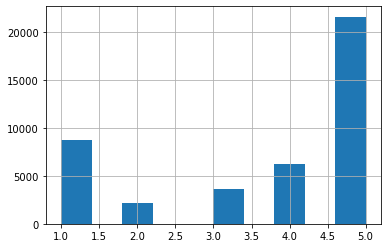

In [53]:
df_reviews.score.hist()

### Logistic Regression

In [54]:
# объеденим ревью с оценками 1-3 в класс 0, с оценками 4-5 в класс 1
# 0 - условно негативные оценки
# 1 - условно положительные оценки

df_reviews['class'] = df_reviews.score.apply(lambda x: 1 if x > 3 else 0)

In [55]:
df_train = df_reviews.sample(frac=0.8, random_state=12)
df_test = df_reviews[~df_reviews.index.isin(df_train.index)].copy()

In [56]:
x_train = df_train['vec'].tolist()
y_train = df_train['class'].tolist()

x_test = df_test['vec'].tolist()
y_test = df_test['class'].tolist()

In [57]:
lr = LogisticRegression(max_iter= 10000, random_state=12, n_jobs=4)

lr.fit(x_train, y_train)

y_preds = lr.predict(x_test)

print("Model score on Training Data = ", lr.score(x_train, y_train)*100,"%")
print("Model score on Testing Data = ", lr.score(x_test, y_test)*100,"%")

Model score on Training Data =  90.3618013338842 %
Model score on Testing Data =  89.43454137646086 %


AUC: 0.8784269198495821


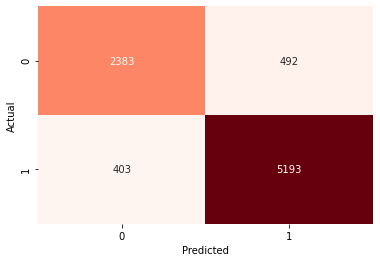

In [58]:
lr_cm = confusion_matrix(y_test, y_preds)

cm = pd.DataFrame(lr_cm, columns=[0,1], index = [0,1])
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

sns.heatmap(cm, cbar=False, cmap="Reds", annot=True, fmt='g')

print('AUC:', roc_auc_score(np.array(y_test), y_preds))

#### Проверим пару комментариев

In [59]:
tests = [
     ['Negative', 'Produto muito ruim! Não compro mais nesta loja, a entrega atrasou e custou muito dinheiro!']
    ,['Positive', 'Eu gosto dele e ele realmente correspondeu às expectativas. Comprei barato. Maravilhoso!']
]

for test in tests:
    print('Comment:', test[1])
    print('Class:', test[0])

    transform_test_bad = vec.transform([words_transform(test[1])]).toarray()
    y_preds = lr.predict(transform_test_bad)

    print('Score:','Negative' if y_preds==0 else 'Positive')
    print('===================================================================================================')

Comment: Produto muito ruim! Não compro mais nesta loja, a entrega atrasou e custou muito dinheiro!
Class: Negative
Score: Negative
Comment: Eu gosto dele e ele realmente correspondeu às expectativas. Comprei barato. Maravilhoso!
Class: Positive
Score: Positive


Неплохое качество модели, можно использовать для прогноза оценки по ревью

#### Посмотрим какие слова преобладают в каждом классе

In [60]:
df_words = df_order_reviews.loc[df_order_reviews['review_text']!='',['order_id','review_text','review_score']].copy()

df_words['class'] = df_words.review_score.apply(lambda x: 1 if x > 3 else 0)
df_words['text_stemmer_false'] = df_words.review_text.apply(lambda x: words_transform(x, st=False))
df_words['text_stemmer_true'] = df_words.review_text.apply(lambda x: words_transform(x, st=True))

In [61]:
df_words['pred'] = df_words['text_stemmer_true'].apply(lambda x: lr.predict(vec.transform([words_transform(x)]).toarray()))

In [62]:
for num_class in [0,1]:
    bw = df_words.loc[df_words['class']==num_class, 'text_stemmer_true'].str.split().tolist()
    bw = [item for sublist in bw for item in sublist]
    
    ex = df_words.loc[df_words['class']==num_class, 'text_stemmer_false'].str.split().tolist()
    ex = [item for sublist in ex for item in sublist]
    
    dct = pd.DataFrame(columns={'word', 'examples'})
    dct['word'] = bw
    dct['examples'] = ex
    
    gdct = dct.groupby(['word'], as_index=False).agg(list)
    gdct['examples'] = gdct['examples'].apply(lambda x: list(set(x)))
    
    words, values = zip(*Counter(bw).items())
    df = pd.DataFrame(columns={'word', 'count'})
    df['word'] = words
    df['count'] = values
    df['%'] = (df['count']/df['count'].sum()*100).apply(lambda x: round(x,1))
    
    res = pd.merge(df, gdct, on='word', how='outer')
    
    print()
    print('Class: ', 'Negative' if num_class==0 else 'Positive')
    display(res[['count','%','word','examples']].sort_values(by='count', ascending=False).head(15).style.hide_index())
    print('===================================================================================================')


Class:  Negative


count,%,word,examples
10898,7,neg,"['neguei', 'negação', 'negaram', 'negada']"
9239,5.9,produt,"['produtor', 'produtos', 'produto', 'produt', 'produti']"
5448,3.5,numer,"['numero', 'numeros', 'numeração']"
4933,3.2,receb,"['receber', 'recebidos', 'receb', 'recebimento', 'recebendo', 'recebermos', 'receberei', 'recebem', 'receba', 'recebesse', 'receberam', 'recebida', 'recebido', 'recebei', 'recebo', 'recebidas', 'receberia', 'recebias', 'recebe', 'recebia', 'recebir', 'recebê', 'receberá', 'recebíamos', 'recebeu', 'recebi', 'recebemos']"
4786,3.1,entreg,"['entreguem', 'entrega', 'entregaria', 'entrege', 'entregarão', 'entregara', 'entregamos', 'entregaram', 'entregada', 'entregá', 'entrego', 'entregar', 'entregou', 'entregas', 'entregues', 'entregador', 'entregadora', 'entregado', 'entregadores', 'entregariam', 'entregam', 'entregarem', 'entreg', 'entregando', 'entregava', 'entregue']"
4220,2.7,compr,"['compras', 'compradas', 'comprada', 'compriu', 'comprimento', 'compre', 'comprou', 'comprei', 'comprarei', 'comprados', 'comprido', 'compro', 'compr', 'compraram', 'compramos', 'comprando', 'comprava', 'comprador', 'comprado', 'compradores', 'compra', 'compram', 'compradora', 'compraria', 'comprem', 'comprar']"
2174,1.4,vei,"['veias', 'veio', 'vei']"
2168,1.4,cheg,"['chega', 'cheguei', 'chegar', 'chegariam', 'chegaram', 'cheg', 'chegaria', 'chegam', 'chegarei', 'chegavam', 'chegamos', 'chegara', 'chegará', 'chego', 'chegada', 'chegarem', 'chegado', 'chegou', 'chegasse', 'chegava', 'chegue', 'chegando']"
1751,1.1,aind,"['ainds', 'ainda', 'aind']"
1525,1,ped,"['pedimos', 'pedindo', 'pedi', 'pedira', 'pedia', 'pediu', 'pedido', 'pedidos', 'pedisse', 'pediram', 'pedir', 'pediria', 'pedidas', 'pedida', 'pedirei', 'pede']"



Class:  Positive


count,%,word,examples
11780,7,produt,"['produtor', 'produtos', 'produt', 'produto']"
7894,4.7,entreg,"['entrega', 'entrege', 'entregarão', 'entregs', 'entregasse', 'entregaram', 'entregada', 'entregá', 'entrego', 'entregassem', 'entregar', 'entregou', 'entregas', 'entregues', 'entregador', 'entregadores', 'entregado', 'entregam', 'entreg', 'entregarem', 'entregando', 'entregue', 'entregarei', 'entreguei']"
7220,4.3,praz,"['praza', 'praz', 'prazos', 'prazer', 'prazo']"
5657,3.4,recom,"['recomendo', 'recom', 'recome']"
5355,3.2,ant,"['anti', 'antes', 'ante', 'antos', 'ant']"
5211,3.1,bom,"['bom', 'bons']"
4449,2.6,cheg,"['chega', 'cheguei', 'chegar', 'chegariam', 'chegarão', 'chegaram', 'chegassem', 'cheg', 'cheguem', 'chegaria', 'chegam', 'chegara', 'chegará', 'chego', 'chegada', 'chegarem', 'chegado', 'chegou', 'chegasse', 'chegava', 'chegue', 'chegando']"
3652,2.2,ótim,"['ótimas', 'ótima', 'ótimo', 'ótimos']"
3315,2,compr,"['compras', 'comprada', 'compriu', 'comprimento', 'compre', 'comprou', 'comprei', 'comprarias', 'comprarem', 'comprados', 'comprarei', 'compro', 'comprido', 'compr', 'comprida', 'comprá', 'compramos', 'comprando', 'comprava', 'comprador', 'comprado', 'compradores', 'compra', 'comprara', 'compradora', 'compraria', 'comprem', 'comprar']"
2713,1.6,bem,['bem']


Наиболее упортебляемые слова в классе с оценками 1-3 связаны с отказами и неполучением товаров: ``['negada', 'neguei', 'negação', 'negaram']``,``['recebida', 'receb', 'recebidas', 'recebesse', 'receba', 'recebo', 'recebíamos', 'recebias', 'recebeu', 'recebidos', 'receberam', 'recebem', 'recebendo', 'receberia', 'recebia', 'receber', 'recebido', 'receberá', 'recebê', 'recebi', 'recebir', 'recebe', 'receberei', 'recebei', 'recebemos', 'recebimento', 'recebermos']``
задержкой товаров, срывом сроков и т.д.

Наиболее упортебляемые слова в классе с оценками 4-5 связаны с положительными/одобрительными прилагательными: ``['recomendo', 'recome', 'recom'], ['excelentes', 'excelante', 'excelente', 'excelência', 'excele'], ['super', 'supera', 'supar', 'supe'],
['ótimo', 'ótima', 'ótimas', 'ótimos'],`` и положительными словами об сроках доставки: ``['rápidíssima', 'rápidos', 'rápida', 'rápidinho', 'rápido', 'rápidas']``

Можно предположить, что оценка и комментарий зависят от сроков доставки товара.

Далее можно развивать модель: разделить данные на категории товаров, посмотреть кластеры этих товаров или групп, возможно там есть какие-то отличия, проверить зависимости от продавцов, по покупателям можно унифицировать оценки.
___________